Copyright 2020 The TensorFlow Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Assess privacy risks with the TensorFlow Privacy Report

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/responsible_ai/privacy/tutorials/privacy_report"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/privacy/blob/master/g3doc/tutorials/privacy_report.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/privacy/blob/master/g3doc/tutorials/privacy_report.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/privacy/g3doc/tutorials/privacy_report.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

##Overview
In this codelab you'll train a simple image classification model on the CIFAR10 dataset, and then use the "membership inference attack" against this model to assess if the attacker is able to "guess" whether a particular sample was present in the training set. You will use the TF Privacy Report to visualize results from multiple models and model checkpoints.

## Setup


In [1]:
import numpy as np
from typing import Tuple
from scipy import special
from sklearn import metrics

import tensorflow as tf

import tensorflow_datasets as tfds

# Set verbosity.
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

### Install TensorFlow Privacy.

In [2]:
!pip install tensorflow_privacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 301 kB 10.8 MB/s 
     |████████████████████████████████| 60 kB 9.5 MB/s 
     |████████████████████████████████| 89 kB 12.0 MB/s 
     |████████████████████████████████| 12.2 MB 60.0 MB/s 
     |████████████████████████████████| 5.7 MB 52.1 MB/s 
     |████████████████████████████████| 9.4 MB 40.6 MB/s 
     |████████████████████████████████| 126 kB 65.7 MB/s 
     |████████████████████████████████| 965 kB 56.3 MB/s 
     |████████████████████████████████| 295 kB 59.3 MB/s 
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.3.0
    Uninstalling absl-py-1.3.0:
      Successfully uninstalled absl-py-1.3.0
  Attempting uninstall: attrs
    Found existing installation: attrs 22.1.0
    Uninstalling attrs-22.1.0:
      Successfully uninstalled attrs-22.1.0
  Attempting uninstall: tensorflow-probability
    Found existing installa

In [3]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackResultsCollection
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyMetric
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyReportMetadata
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import privacy_report

In [4]:
import tensorflow_privacy

## Train two models, with privacy metrics

This section trains a pair of `keras.Model` classifiers on the `CIFAR-10` dataset. During the training process it collects privacy metrics, that will be used to generate reports in the bext section.

The first step is to define some hyperparameters:

In [5]:
dataset = 'cifar10'
num_classes = 10
activation = 'relu'
num_conv = 3

batch_size=50
epochs_per_report = 2
total_epochs = 50

lr = 0.001

Next, load the dataset. There's nothing privacy-specific in this code.

In [6]:
#@title
print('Loading the dataset.')
train_ds = tfds.as_numpy(
    tfds.load(dataset, split=tfds.Split.TRAIN, batch_size=-1))
test_ds = tfds.as_numpy(
    tfds.load(dataset, split=tfds.Split.TEST, batch_size=-1))
x_train = train_ds['image'].astype('float32') / 255.
y_train_indices = train_ds['label'][:, np.newaxis]
x_test = test_ds['image'].astype('float32') / 255.
y_test_indices = test_ds['label'][:, np.newaxis]

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train_indices, num_classes)
y_test = tf.keras.utils.to_categorical(y_test_indices, num_classes)

input_shape = x_train.shape[1:]

assert x_train.shape[0] % batch_size == 0, "The tensorflow_privacy optimizer doesn't handle partial batches"

Loading the dataset.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteG6EO5I/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteG6EO5I/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


Next define a function to build the models.

In [7]:
#@title
def small_cnn(input_shape: Tuple[int],
              num_classes: int,
              num_conv: int,
              activation: str = 'relu') -> tf.keras.models.Sequential:
  """Setup a small CNN for image classification.

  Args:
    input_shape: Integer tuple for the shape of the images.
    num_classes: Number of prediction classes.
    num_conv: Number of convolutional layers.
    activation: The activation function to use for conv and dense layers.

  Returns:
    The Keras model.
  """
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=input_shape))

  # Conv layers
  for _ in range(num_conv):
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation=activation))
    model.add(tf.keras.layers.MaxPooling2D())

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation=activation))
  model.add(tf.keras.layers.Dense(num_classes))
  
  model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=['accuracy'])

  return model

Build two three-layer CNN models using that function.

Configure the first to use a basic SGD optimizer, an the second to use a differentially private optimizer (`tf_privacy.DPKerasAdamOptimizer`), so you can compare the results.

In [8]:
model_2layers = small_cnn(
    input_shape, num_classes, num_conv=2, activation=activation)
model_3layers = small_cnn(
    input_shape, num_classes, num_conv=3, activation=activation)

### Define a callback to collect privacy metrics

Next define a `keras.callbacks.Callback` to periorically run some privacy attacks against the model, and log the results.

The keras `fit` method will call the `on_epoch_end` method after each training epoch. The `n` argument is the (0-based) epoch number.

You could implement this procedure by writing a loop that repeatedly calls `Model.fit(..., epochs=epochs_per_report)` and runs the attack code. The callback is used here just because it gives a clear separation between the training logic, and the privacy evaluation logic.


In [9]:
class PrivacyMetrics(tf.keras.callbacks.Callback):
  def __init__(self, epochs_per_report, model_name):
    self.epochs_per_report = epochs_per_report
    self.model_name = model_name
    self.attack_results = []

  def on_epoch_end(self, epoch, logs=None):
    epoch = epoch+1

    if epoch % self.epochs_per_report != 0:
      return

    print(f'\nRunning privacy report for epoch: {epoch}\n')

    logits_train = self.model.predict(x_train, batch_size=batch_size)
    logits_test = self.model.predict(x_test, batch_size=batch_size)

    prob_train = special.softmax(logits_train, axis=1)
    prob_test = special.softmax(logits_test, axis=1)

    # Add metadata to generate a privacy report.
    privacy_report_metadata = PrivacyReportMetadata(
        # Show the validation accuracy on the plot
        # It's what you send to train_accuracy that gets plotted.
        accuracy_train=logs['val_accuracy'], 
        accuracy_test=logs['val_accuracy'],
        epoch_num=epoch,
        model_variant_label=self.model_name)

    attack_results = mia.run_attacks(
        AttackInputData(
            labels_train=y_train_indices[:, 0],
            labels_test=y_test_indices[:, 0],
            probs_train=prob_train,
            probs_test=prob_test),
        SlicingSpec(entire_dataset=True, by_class=True),
        attack_types=(AttackType.THRESHOLD_ATTACK,
                      AttackType.LOGISTIC_REGRESSION),
        privacy_report_metadata=privacy_report_metadata)

    self.attack_results.append(attack_results)


### Train the models

The next code block trains the two models. The `all_reports` list is used to collect all the results from all the models' training runs. The individual reports are tagged witht the `model_name`, so there's no confusion about which model generated which report.

In [11]:
all_reports = []

In [10]:
callback = PrivacyMetrics(epochs_per_report, "2 Layers")
history = model_2layers.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=total_epochs,
      validation_data=(x_test, y_test),
      callbacks=[callback],
      shuffle=True)

all_reports.extend(callback.attack_results)

Epoch 1/50
1000/1000 [==============================] - 17s 8ms/step - loss: 1.5596 - accuracy: 0.4333 - val_loss: 1.2930 - val_accuracy: 0.5337
Epoch 2/50
 992/1000 [============================>.] - ETA: 0s - loss: 1.2184 - accuracy: 0.5695
Running privacy report for epoch: 2

1000/1000 [==============================] - 22s 22ms/step - loss: 1.2175 - accuracy: 0.5700 - val_loss: 1.1502 - val_accuracy: 0.5936
Epoch 3/50
1000/1000 [==============================] - 4s 4ms/step - loss: 1.0888 - accuracy: 0.6225 - val_loss: 1.1359 - val_accuracy: 0.6021
Epoch 4/50
1000/1000 [==============================] - ETA: 0s - loss: 1.0148 - accuracy: 0.6476
Running privacy report for epoch: 4

1000/1000 [==============================] - 18s 18ms/step - loss: 1.0148 - accuracy: 0.6476 - val_loss: 1.0727 - val_accuracy: 0.6276
Epoch 5/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.9552 - accuracy: 0.6684 - val_loss: 1.0183 - val_accuracy: 0.6495
Epoch 6/50
 997/1000 [=====

NameError: ignored

In [12]:
all_reports.extend(callback.attack_results)

In [ ]:
callback = PrivacyMetrics(epochs_per_report, "3 Layers")
history = model_3layers.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=total_epochs,
      validation_data=(x_test, y_test),
      callbacks=[callback],
      shuffle=True)

all_reports.extend(callback.attack_results)

## Epoch Plots

You can visualize how privacy risks happen as you train models by probing the model periodically (e.g. every 5 epochs), you can pick the point in time with the best performance / privacy trade-off.

Use the TF Privacy Membership Inference Attack module to generate `AttackResults`. These `AttackResults` get combined into an `AttackResultsCollection`. The TF Privacy Report is designed to analyze the provided `AttackResultsCollection`.

In [13]:
results = AttackResultsCollection(all_reports)

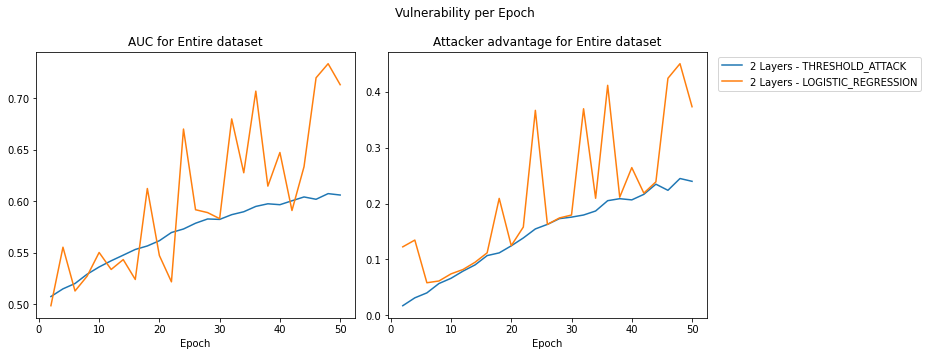

In [16]:
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
epoch_plot = privacy_report.plot_by_epochs(
    results, privacy_metrics=privacy_metrics)

See that as a rule, privacy vulnerability tends to increase as the number of epochs goes up. This is true across model variants as well as different attacker types.

Two layer models (with fewer convolutional layers) are generally more vulnerable than their three layer model counterparts.

Now let's see how model performance changes with respect to privacy risk.

## Privacy vs Utility

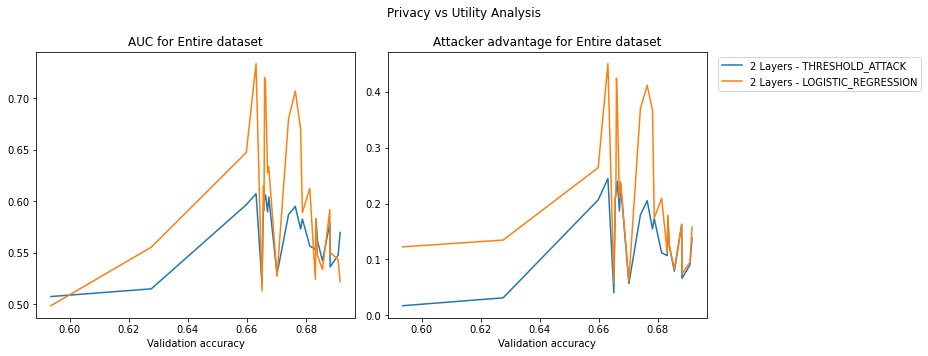

In [17]:
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
utility_privacy_plot = privacy_report.plot_privacy_vs_accuracy(
    results, privacy_metrics=privacy_metrics)

for axis in utility_privacy_plot.axes:
  axis.set_xlabel('Validation accuracy')

Three layer models (perhaps due to too many parameters) only achieve a train accuracy of 0.85. The two layer models achieve roughly equal performance for that level of privacy risk but they continue to get better accuracy.

You can also see how the line for two layer models gets steeper. This means that additional marginal gains in train accuracy come at an expense of vast privacy vulnerabilities.

This is the end of the tutorial. Feel free to analyze your own results.